In [132]:
import sys
from pathlib import Path

project_root = str(Path().resolve().parent.parent)
if project_root not in sys.path:
    sys.path.insert(0, project_root)


from src.database.DatabaseConnection import DatabaseConnection
from src.preprocess.preprocessing import preprocess_data

from scripts.gpu_metrics import get_requested_vram
import pandas as pd
import numpy as np 

project_root = str(Path().resolve().parent.parent)
if project_root not in sys.path:
    sys.path.insert(0, project_root)


In [28]:
def load_jobs_dataframe_from_duckdb(db_path=None, table_name="Jobs"):
    """
    Connect to the DuckDB slurm_data_small.db and return the jobs table as a pandas DataFrame.

    Args:
        db_path (str or Path, optional): Path to the DuckDB database. Defaults to 'data/slurm_data_small.db'.
        table_name (str, optional): Table name to query. Defaults to 'Jobs'.

    Returns:
        pd.DataFrame: DataFrame containing the table data.
    """
    if db_path is None:
        db_path = Path(__file__).resolve().parents[2] / "data" / "slurm_data_small.db"
    db = DatabaseConnection(str(db_path))

    df = db.fetch_all(table_name=table_name)
    data = preprocess_data(df, min_elapsed_second=0, include_failed_cancelled_jobs=False)
    db.disconnect()
    return data

In [29]:
"""load jobs dataframe from duckdb"""
jobs_df = load_jobs_dataframe_from_duckdb(db_path="C:\\Users\\Nitya Karthik A\\ds4cg-job-analytics\\data\\slurm_data.db", table_name="Jobs")


Connected to C:\Users\Nitya Karthik A\ds4cg-job-analytics\data\slurm_data.db


In [43]:
ram_map = {
    "a100": 80,
    "v100": 16,
    "a40": 48,
    "gh200": 95,
    "rtx_8000": 48,
    "2080_ti": 11,
    "1080_ti": 11,
    "2080": 8,
    "h100": 80,
    "l4": 23,
    "m40": 23,
    "l40s": 48,
    "titan_x": 12,
    "a16": 16,
}

def normalize_gpu_type(gpu_type):
    """
    Normalize GPU type string to match keys in ram_map.
    Handles vendor prefixes, dashes, underscores, and case.
    """
    if not isinstance(gpu_type, str):
        return None
    s = gpu_type.strip().lower()
    for prefix in ["nvidia ", "nvidia-", "nvidia_"]:
        if s.startswith(prefix):
            s = s[len(prefix):]
    for suffix in ["-pcie", "_pcie", "-sxm", "_sxm", " pcie", " sxm"]:
        if s.endswith(suffix):
            s = s[: -len(suffix)]
    import re
    s = re.sub(r"[^a-z0-9]", "_", s)
    s = re.sub(r"_+", "_", s)
    s = s.strip("_")
    return s
def add_allocated_vram_column(df):
    """
    Add a column for allocated VRAM based on the GPUType field.

    Args:
        df (DataFrame): Main job dataframe from GPUMetrics

    Returns:
        DataFrame: DataFrame with allocated_vram column added
    """
    def get_allocated_vram(x):
        if x is None or (isinstance(x, float) and pd.isna(x)):
            return pd.NA
        if isinstance(x, (np.ndarray,)):
            x = x.tolist()
        if isinstance(x, list | tuple) and x:
            vals = []
            for t in x:
                if isinstance(t, str):
                    norm = normalize_gpu_type(t)
                    v = ram_map.get(norm, pd.NA)
                    vals.append(v)
            vals = [v for v in vals if pd.notna(v) and v > 0]
            return min(vals) if vals else pd.NA
        elif isinstance(x, str):
            norm = normalize_gpu_type(x)
            v = ram_map.get(norm, pd.NA)
            return v if pd.notna(v) and v > 0 else pd.NA
        else:
            return pd.NA    
    df["allocated_vram"] = df["GPUType"].apply(get_allocated_vram)
    
    return df 


def add_requested_vram_column(df):
    def safe_get_requested_vram(c):
        # Convert numpy array to list
        if isinstance(c, (np.ndarray,)):
            c = c.tolist()
        # Remove quotes from each constraint
        if isinstance(c, list):
            c = [s.strip("'") for s in c]
        return get_requested_vram(c) if isinstance(c, list) else 0
    df["requested_vram"] = df["Constraints"].apply(safe_get_requested_vram)
    return df    
    

In [ ]:
"""
filter out all entries that use a100 
"""
print(jobs_df['GPUType'])
def contains_a100(gpu_array):
    if isinstance(gpu_array, (list, np.ndarray)):
        return any(str(gpu).strip().lower() == 'a100' for gpu in gpu_array)
    return False

a100_jobs_df = jobs_df[jobs_df['GPUType'].apply(contains_a100)]




20         [rtx_8000]
21             [a100]
22             [l40s]
23             [l40s]
24             [l40s]
              ...    
8523589        [a100]
8523592        [a100]
8523595        [a100]
8523668        [a100]
8523669    [rtx_8000]
Name: GPUType, Length: 956118, dtype: object

In [42]:
print(len(a100_jobs_df))

202886



In [ ]:
def filter_a100_gpus_from_dataframe(df):
    df = add_requested_vram_column(df)
    df = add_allocated_vram_column(df)
    df = df[df['GPUType'].apply(contains_a100)]
    
    return df 


In [130]:
def a100_gpu_metrics(a100_df):
    metrics = a100_df.copy()
    metrics["gpu_memory_used_gb"] = metrics['GPUMemUsage'] / (2**30)
    metrics['num_a100_jobs'] = len(metrics)
    metrics['vram_wasted'] = metrics["allocated_vram"] - metrics["gpu_memory_used_gb"]
    metrics["request_accuracy"] = metrics["gpu_memory_used_gb"] / metrics["requested_vram"]
    metrics["allocation_accuracy"] = metrics["gpu_memory_used_gb"] / metrics["allocated_vram"]
    metrics["request_to_allocation_ratio"] = metrics["allocated_vram"] / metrics["requested_vram"]

    metrics['allocation_efficiency_category'] = pd.cut(
            metrics['allocation_accuracy'],
            bins=[0, 0.2, 0.5, 0.8, 1.0],
            labels=['Very Poor (<20%)', 'Poor (20-50%)', 'Fair (50-80%)', 'Good (80-100%)']
        )
        # Categorize request accuracy
    metrics['request_accuracy_category'] = pd.cut(
            metrics['request_accuracy'],
            bins=[0, 0.5, 0.8, 1.2, 2.0, float('inf')],
            labels=[
    'Severely under-estimated (>200%)',
    'Over-estimated (120-200%)',
    'Accurate (80-120%)',
    'Somewhat over-estimated (50-80%)',
    'Severely over-estimated (<50%)'
]
        )
        # Categorize allocation vs request
    metrics['allocation_type'] = pd.cut(
            metrics['request_to_allocation_ratio'],
            bins=[0, 0.8, 1.0, 1.5, 2.0, float('inf')],
            labels=['Under-allocated (<80%)', 'Exact allocation (80-100%)',
                    'Moderate over-allocation (100-150%)', 'High over-allocation (150-200%)',
                    'Extreme over-allocation (>200%)']
        )
        # Request size categories
    metrics['request_size_category'] = pd.cut(
            metrics['requested_vram'],
            bins=[0, 8, 16, 32, 64, float('inf')],
            labels=['Small (≤8GB)', 'Medium (8-16GB)', 'Large (16-32GB)',
                    'Very Large (32-64GB)', 'Extreme (>64GB)']
        )
    return metrics

In [131]:
a100_gpu_metrics = a100_gpu_metrics(a100_jobs_df)

In [102]:
def create_a100_visualizations(efficiency_jobs_df):
    """
    Creates visualizations for VRAM allocation efficiency.

    Args:
        efficiency_jobs_df (DataFrame): DataFrame containing job data with VRAM allocations.

    Returns:
        None
    """
    # Example visualization: Clean, readable subplots for VRAM allocation analysis
    import matplotlib.pyplot as plt
    import seaborn as sns
    sns.set(style="whitegrid", font_scale=1.1)

    fig, ax = plt.subplots(3, 2, figsize=(18, 14))
    fig.subplots_adjust(hspace=0.4, wspace=0.3)

    # VRAM Allocation Efficiency Distribution
    alloc_counts = efficiency_jobs_df['allocation_efficiency_category'].value_counts().sort_index()
    sns.barplot(x=alloc_counts.index.astype(str), y=alloc_counts.values, ax=ax[0,0], palette="Blues_d")
    ax[0,0].set_title('VRAM Allocation Efficiency Distribution')
    ax[0,0].set_xlabel('Allocation Efficiency Category')
    ax[0,0].set_ylabel('Number of Jobs')

    ax[0,0].tick_params(axis='x', rotation=15)

    # Request Accuracy Distribution
    req_counts = efficiency_jobs_df['request_accuracy_category'].value_counts().sort_index()
    sns.barplot(x=req_counts.index.astype(str), y=req_counts.values, ax=ax[0,1], palette="Greens_d")
    ax[0,1].set_title('Request Accuracy Distribution')
    ax[0,1].set_xlabel('Request Accuracy Category')
    ax[0,1].set_ylabel('Number of Jobs')
    ax[0,1].tick_params(axis='x', rotation=15)

    # Allocation Efficiency vs Request Accuracy
    sns.scatterplot(
        x='allocation_accuracy', y='request_accuracy',
        data=efficiency_jobs_df, ax=ax[1,0], alpha=0.6, edgecolor='k'
    )
    ax[1,0].set_title('Allocation Efficiency vs Request Accuracy')
    ax[1,0].set_xlabel('Allocation Efficiency')
    ax[1,0].set_ylabel('Request Accuracy')
    #ax[1,0].grid(True)

    # VRAM Wasted vs GPU Memory Used
    sns.scatterplot(
        x='gpu_memory_used_gb', y='vram_wasted',
        data=efficiency_jobs_df, ax=ax[1,1], alpha=0.6, color='crimson', edgecolor='k'
    )
    ax[1,1].set_title('VRAM Wasted vs GPU Memory Used')
    ax[1,1].set_xlabel('GPU Memory Used (GB)')
    ax[1,1].set_ylabel('VRAM Wasted (GB)')
    #ax[1,1].grid(True)

        # VRAM Used vs Allocated
    sns.scatterplot(
        x='allocated_vram', y='gpu_memory_used_gb',
        data=efficiency_jobs_df, ax=ax[2,0], alpha=0.6, color='purple', edgecolor='k'
    )
    ax[2,0].plot([
        0, efficiency_jobs_df['allocated_vram'].max()
    ], [
        0, efficiency_jobs_df['allocated_vram'].max()
    ], 'k--', lw=1, label='Ideal (Used=Allocated)')
    ax[2,0].set_title('VRAM Used vs Allocated')
    ax[2,0].set_xlabel('Allocated VRAM (GB)')
    ax[2,0].set_ylabel('GPU Memory Used (GB)')
    ax[2,0].legend()
    #ax[2,0].grid(True)

      # Remove grid lines for all axes
    for row in ax:
        for a in row:
            a.grid(False)

    # Make all subplot titles, xlabels, ylabels smaller
    for row in ax:
        for a in row:
            a.title.set_fontsize(10)
            a.xaxis.label.set_fontsize(8)
            a.yaxis.label.set_fontsize(8)
            a.tick_params(axis='both', labelsize=7)
    fig.suptitle('GPU Job VRAM Allocation Analysis', fontsize=12, y=1.02)
    fig.tight_layout()
    plt.show()


C:\Users\Nitya Karthik A\AppData\Local\Temp\ipykernel_19660\2078915226.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=alloc_counts.index.astype(str), y=alloc_counts.values, ax=ax[0,0], palette="Blues_d")
C:\Users\Nitya Karthik A\AppData\Local\Temp\ipykernel_19660\2078915226.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=req_counts.index.astype(str), y=req_counts.values, ax=ax[0,1], palette="Greens_d")
C:\Users\Nitya Karthik A\AppData\Local\Temp\ipykernel_19660\2078915226.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=

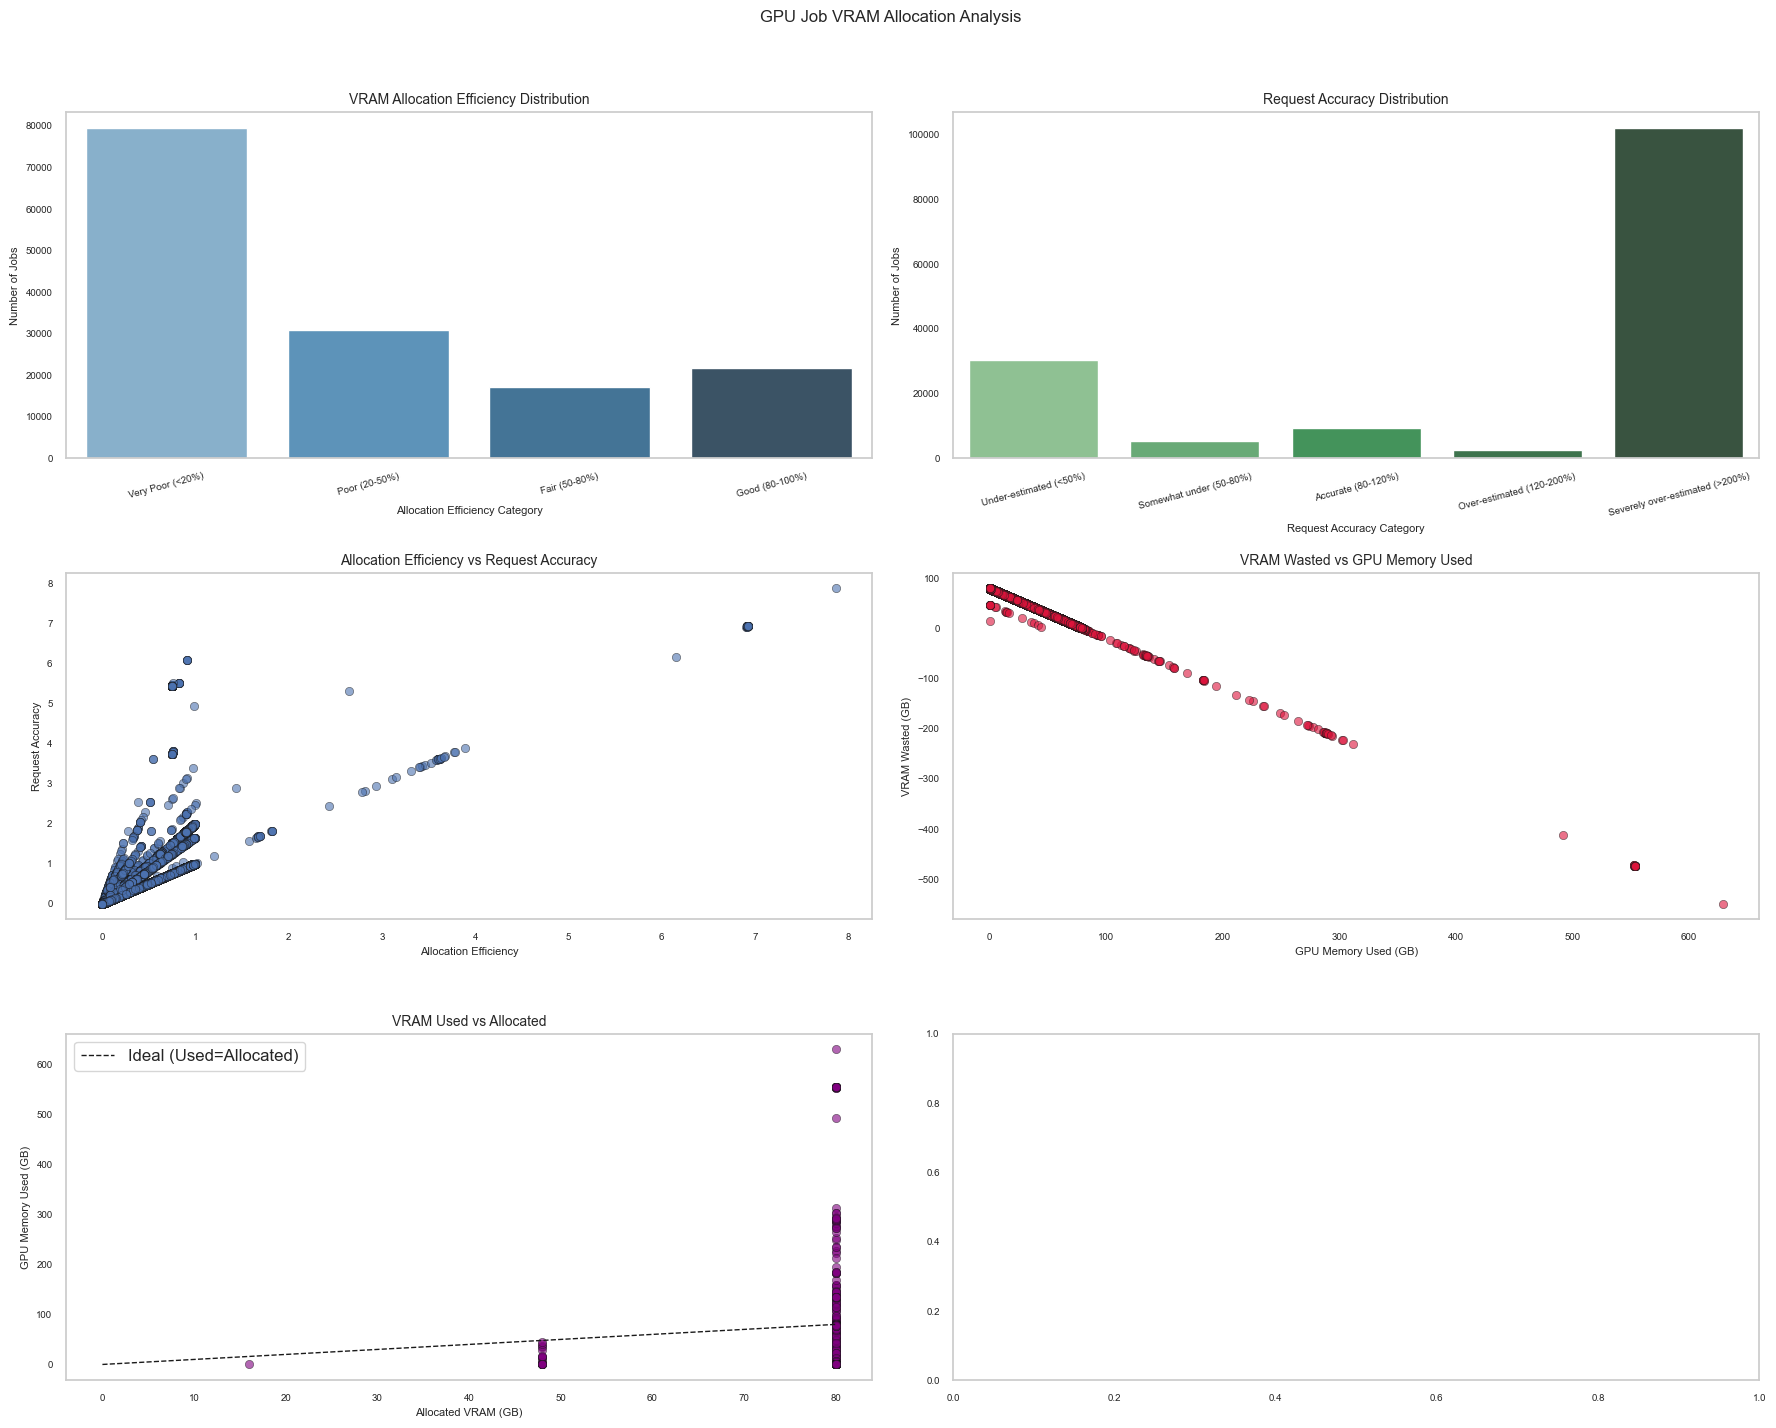

In [90]:
"""Within all of the users who recieved a100, we want to observe different subsets of users. 
i.e: did they request a constraint, or did they request an a100?
args: a100_users_df, arbitrary query, extract information 
 """
create_a100_visualizations(a100_gpu_metrics)

C:\Users\Nitya Karthik A\AppData\Local\Temp\ipykernel_19660\2078915226.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=alloc_counts.index.astype(str), y=alloc_counts.values, ax=ax[0,0], palette="Blues_d")
C:\Users\Nitya Karthik A\AppData\Local\Temp\ipykernel_19660\2078915226.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=req_counts.index.astype(str), y=req_counts.values, ax=ax[0,1], palette="Greens_d")
C:\Users\Nitya Karthik A\AppData\Local\Temp\ipykernel_19660\2078915226.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=

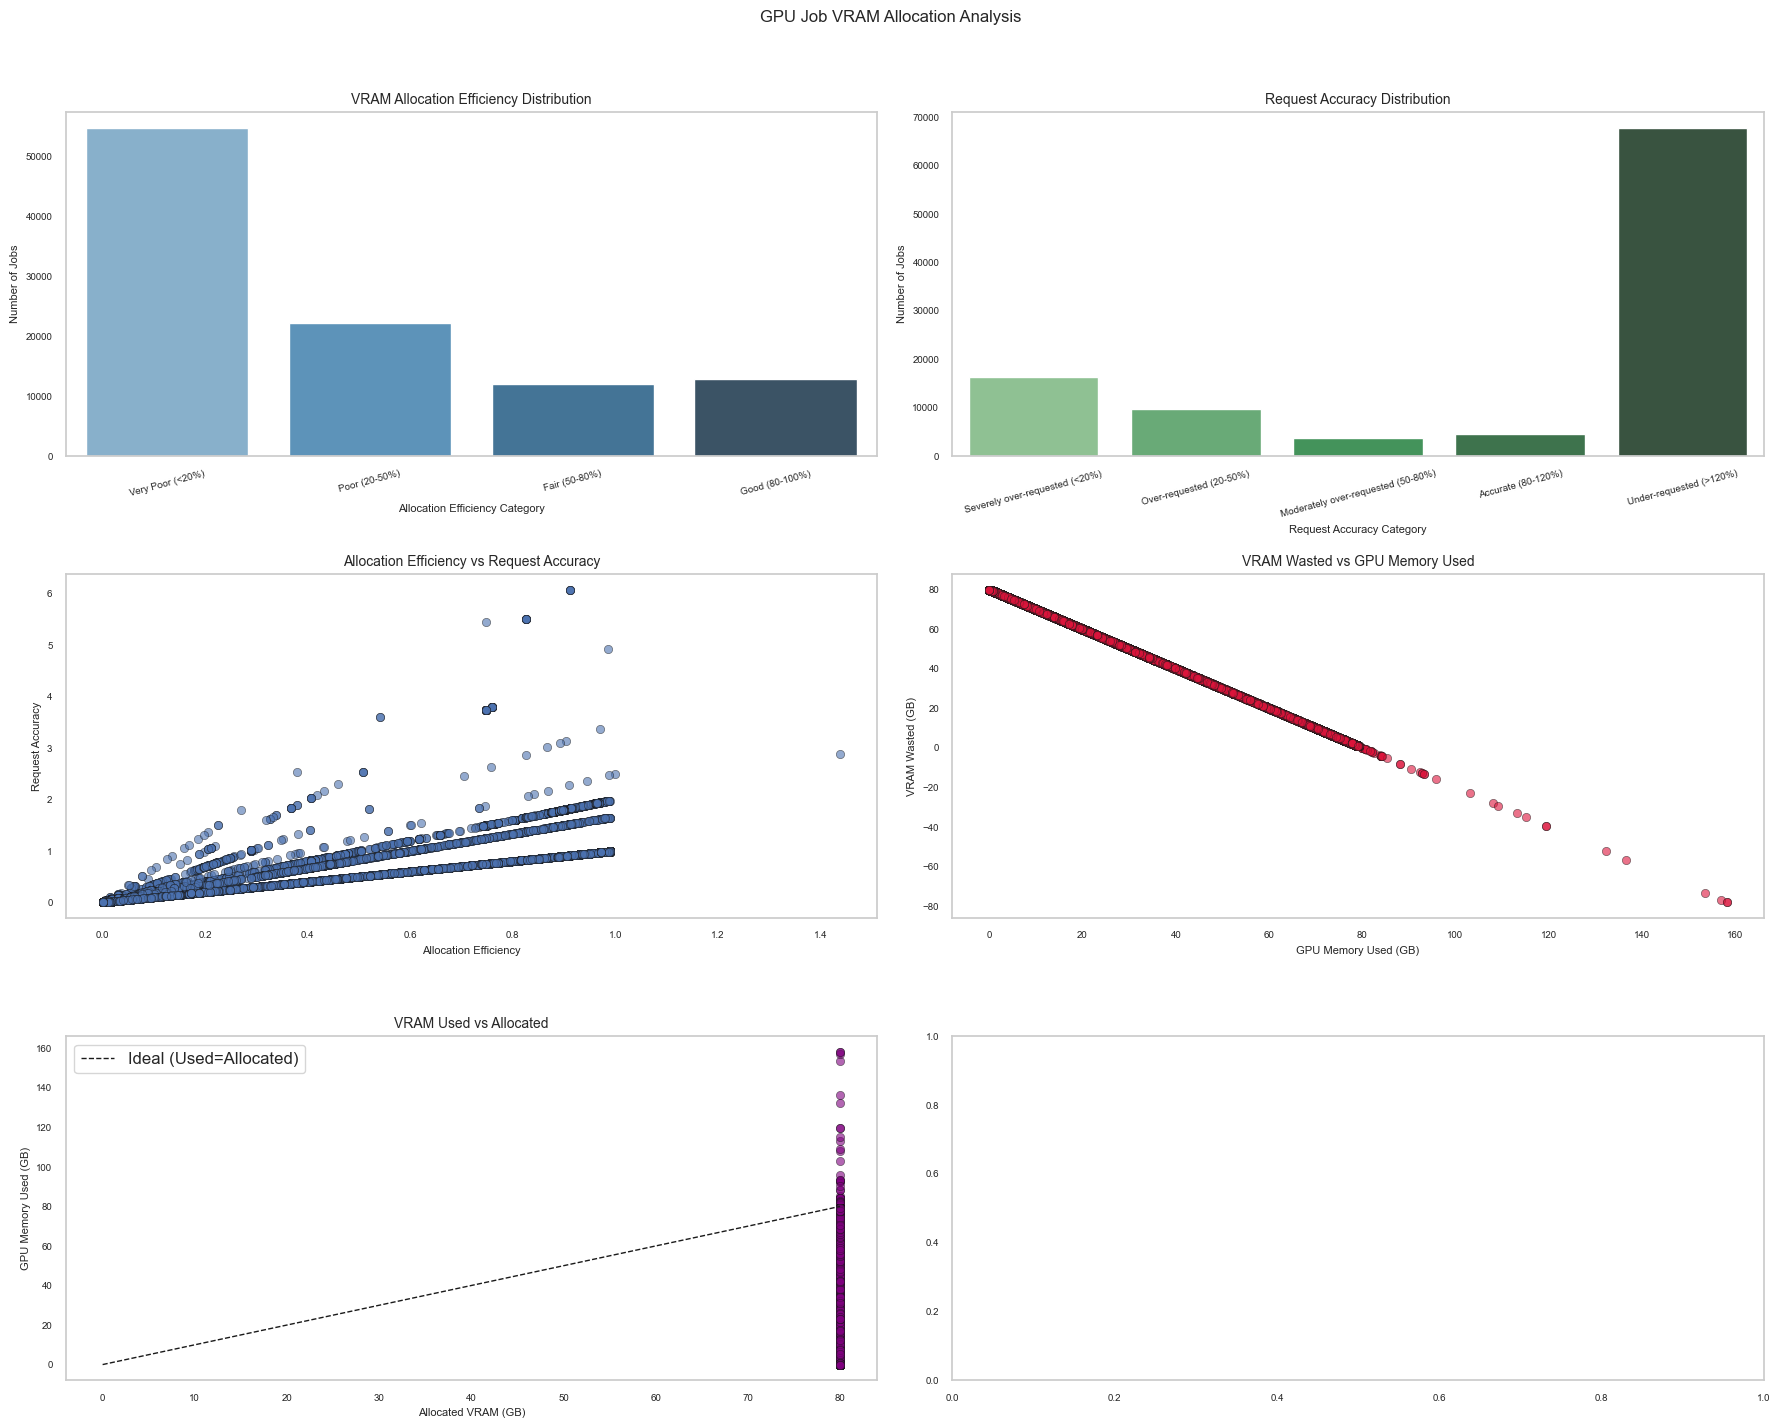

In [103]:
#filter out all entries which have ARRAYJOBS == FALSE and GPUs == 1 and regenerate plots 
a100_gpu_metrics_filtered = a100_gpu_metrics[(a100_gpu_metrics['GPUs'] == 1) & (a100_gpu_metrics['IsArray'] == False)]
create_a100_visualizations(a100_gpu_metrics_filtered)

In [119]:
# Remove rows where request_accuracy is NaN or infinite
a100_gpu_metrics_valid = a100_gpu_metrics[
    a100_gpu_metrics['request_accuracy'].notna() &
    np.isfinite(a100_gpu_metrics['request_accuracy'])
]
filtered_values = a100_gpu_metrics_valid['request_accuracy'][a100_gpu_metrics_valid['request_accuracy'] < 1]
print(filtered_values)

21         0.988501
81         0.293164
82         0.293164
93         0.037194
143        0.062670
             ...   
8516594    0.988721
8523473    0.000000
8523474    0.000000
8523585    0.000000
8523668    0.000000
Name: request_accuracy, Length: 55260, dtype: float64



C:\Users\Nitya Karthik A\AppData\Local\Temp\ipykernel_19660\1140770270.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=bin_counts.index, y=bin_counts.values, palette="Blues_d")


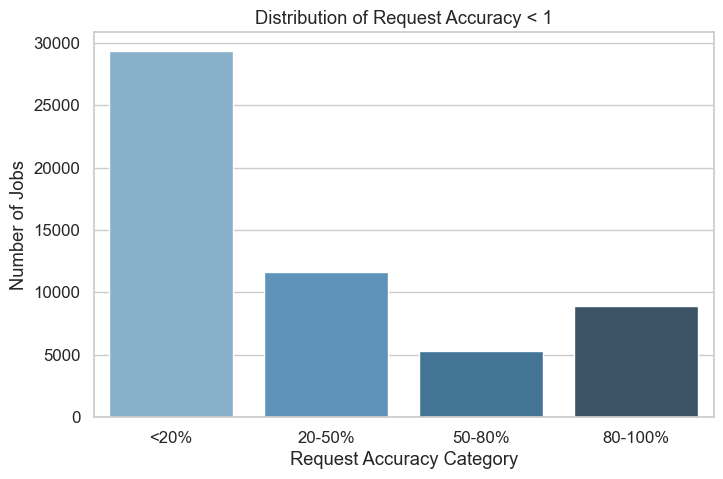

In [120]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define bins and labels for the categories
bins = [0, 0.2, 0.5, 0.8, 1.0]
labels = ['<20%', '20-50%', '50-80%', '80-100%']

# Bin the filtered values
filtered_values_binned = pd.cut(filtered_values, bins=bins, labels=labels, include_lowest=True)

# Count the number of values in each bin
bin_counts = filtered_values_binned.value_counts().sort_index()

# Plot the distribution
plt.figure(figsize=(8, 5))
sns.barplot(x=bin_counts.index, y=bin_counts.values, palette="Blues_d")
plt.title('Distribution of Request Accuracy < 1')
plt.xlabel('Request Accuracy Category')
plt.ylabel('Number of Jobs')
plt.show()


In [126]:
print(a100_gpu_metrics['Constraints'])


21         ['gpu:a100']
81         ['gpu:a100']
82         ['gpu:a100']
93           ['vram23']
143          ['vram23']
               ...     
8523585    ['gpu:a100']
8523589              []
8523592              []
8523595              []
8523668    ['gpu:a100']
Name: Constraints, Length: 202886, dtype: object

